In [22]:
import base64
import io
import json
import os
import re
import uuid

import chromadb
from dotenv import dotenv_values, load_dotenv
from IPython.display import HTML, display
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_chroma import Chroma
from langchain_community.chat_models import AzureChatOpenAI
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image

# Load environment variables from .env file
if os.path.exists("../.env"):
    load_dotenv(override=True)
    config = dotenv_values("../.env")

import langchain

langchain.debug = True

embedding_model_name = os.environ.get("EMBEDDING_MODEL_NAME", "text-embedding-3-large")
from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(
    model="text-embedding-3-large",
    # dimensions: Optional[int] = None, # Can specify dimensions with new text-embedding-3 models
    # azure_endpoint="https://<your-endpoint>.openai.azure.com/", If not provided, will read env variable AZURE_OPENAI_ENDPOINT
    # api_key=... # Can provide an API key directly. If missing read env variable AZURE_OPENAI_API_KEY
    # openai_api_version=..., # If not provided, will read env variable AZURE_OPENAI_API_VERSION
)
chromadb_host = os.getenv("CHROMA_HOST", "localhost")
chromadb_port = os.getenv("CHROMA_PORT", "8000")
redis_url = os.getenv("REDIS_URL", "redis://localhost:6379")
persistent_client_chroma = chromadb.HttpClient(host=chromadb_host, port=chromadb_port)

import redis
from langchain_community.storage import RedisStore

redis_host, redis_port = redis_url.split("redis://")[1].split(":")
redis_client = redis.StrictRedis(host=redis_host, port=redis_port, decode_responses=True)

redis_store = RedisStore(client=redis_client, namespace="multimodalrag")

# The vectorstore to use to index the summaries
vectorstore = Chroma(
    client=persistent_client_chroma,
    collection_name="multimodalrag",
    embedding_function=embeddings,
)

In [23]:
# Remove stuff from collection
redis_client.flushdb()
vectorstore.delete_collection()

In [ ]:
def load_serialized_data(output_folder):
    """
    Load all serialized data from the output folder structure
    Returns dictionaries of texts, tables, and images organized by file name
    """
    all_texts = {}
    all_tables = {}
    all_images = {}

    # Iterate through each subfolder (one per processed file)
    for folder_name in os.listdir(output_folder):
        folder_path = os.path.join(output_folder, folder_name)

        if not os.path.isdir(folder_path):
            continue

        # Load texts
        text_path = os.path.join(folder_path, "texts.json")
        if os.path.exists(text_path):
            with open(text_path, "r", encoding="utf-8") as f:
                all_texts[folder_name] = json.load(f)

        # Load tables
        table_path = os.path.join(folder_path, "tables.json")
        if os.path.exists(table_path):
            with open(table_path, "r", encoding="utf-8") as f:
                all_tables[folder_name] = json.load(f)

        # Load images from the images subfolder
        images_folder = os.path.join(folder_path, "images")
        if os.path.exists(images_folder):
            all_images[folder_name] = []
            for img_file in os.listdir(images_folder):
                if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
                    img_path = os.path.join(images_folder, img_file)
                    # Create a tuple of (image_name, base64_string)
                    img_base64 = encode_image(img_path)
                    all_images[folder_name].append((img_file, img_base64))

    return all_texts, all_tables, all_images


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def generate_text_summaries(texts_dict, tables_dict, summarize_texts=False):
    """
    Summarize text elements organized by file
    texts_dict: Dictionary of texts by file name
    tables_dict: Dictionary of tables by file name
    summarize_texts: Bool to summarize texts
    """
    text_summaries = {}
    table_summaries = {}

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval.
    Table or text: {element}
    """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    model = AzureChatOpenAI(temperature=0, model="gpt-4o", deployment_name="gpt-4o")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Process texts by file
    for file_name, texts in texts_dict.items():
        if texts and summarize_texts:
            text_summaries[file_name] = summarize_chain.batch(texts, {"max_concurrency": 5})
        elif texts:
            text_summaries[file_name] = texts

    # Process tables by file
    for file_name, tables in tables_dict.items():
        if tables:
            table_summaries[file_name] = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


def generate_img_summaries(images_dict):
    """
    Generate summaries for images organized by file
    images_dict: Dictionary of (image_name, base64_string) tuples by file name
    """
    image_summaries = {}

    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    chat = AzureChatOpenAI(model="gpt-4o", max_tokens=2048, deployment_name="gpt-4o")

    for file_name, images in images_dict.items():
        image_summaries[file_name] = []
        for img_name, img_base64 in images:
            msg = chat.invoke(
                [
                    HumanMessage(
                        content=[
                            {"type": "text", "text": prompt},
                            {
                                "type": "image_url",
                                "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                            },
                        ]
                    )
                ]
            )
            image_summaries[file_name].append((img_name, msg.content))

    return image_summaries


# Usage example:
output_folder = "../data/output"
texts_dict, tables_dict, images_dict = load_serialized_data(output_folder)

# Generate summaries if needed
text_summaries_dict, table_summaries_dict = generate_text_summaries(
    texts_dict, tables_dict, summarize_texts=True
)
image_summaries_dict = generate_img_summaries(images_dict)

In [2]:
def create_multi_vector_retriever(
    vectorstore,
    text_summaries_dict,
    texts_dict,
    table_summaries_dict,
    tables_dict,
    image_summaries_dict,
    images_dict,
    redis_store,
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    All inputs are dictionaries keyed by file names
    """
    # Initialize the storage layer
    store = redis_store
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents, file_name):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(
                page_content=s, metadata={id_key: doc_ids[i], "file_name": file_name, "index": i}
            )
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents, strict=False)))

    # Process each file's content
    for file_name in text_summaries_dict.keys():
        # Add texts if available
        if text_summaries_dict.get(file_name):
            add_documents(
                retriever, text_summaries_dict[file_name], texts_dict[file_name], file_name
            )

        # Add tables if available
        if table_summaries_dict.get(file_name):
            add_documents(
                retriever, table_summaries_dict[file_name], tables_dict[file_name], file_name
            )

        # Add images if available
        if image_summaries_dict.get(file_name):
            # Extract summaries and images separately from tuples
            summaries = [summary for _, summary in image_summaries_dict[file_name]]
            images = [img_data for _, img_data in images_dict[file_name]]
            add_documents(retriever, summaries, images, file_name)

    return retriever


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts while preserving metadata
    """
    b64_images = []
    texts = []

    for doc in docs:
        content = doc.page_content if isinstance(doc, Document) else doc
        metadata = doc.metadata if isinstance(doc, Document) else {}

        if looks_like_base64(content) and is_image_data(content):
            resized_content = resize_base64_image(content, size=(1300, 600))
            b64_images.append({"content": resized_content, "metadata": metadata})
        else:
            texts.append({"content": content, "metadata": metadata})

    return {"images": b64_images, "texts": texts}


# Example usage:
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries_dict,
    texts_dict,
    table_summaries_dict,
    tables_dict,
    image_summaries_dict,
    images_dict,
    redis_store,
)

NameError: name 'vectorstore' is not defined

In [20]:
def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are an assistant for a company called DFDS.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to answer the question made by the user. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = AzureChatOpenAI(model="gpt-4o", max_tokens=2048, deployment_name="gpt-4o")

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

In [21]:
# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)
# Check retrieval
query = "Tell me something about London from the data."
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=6)

# We get docs
len(docs)
# Run RAG chain
chain_multimodal_rag.invoke(query)

NameError: name 'retriever_multi_vector_img' is not defined

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "input": "Tell me something about London bridge."
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question>] Entering Chain run with input:
{
  "input": "Tell me something about London bridge."
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableSequence] Entering Chain run with input:
{
  "input": "Tell me something about London bridge."
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnablePassthrough] Entering Chain run with input:
{
  "input": "Tell me something about London bridge."
}
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "output": "Tell me something about London bridge."
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableSequence > chain:s
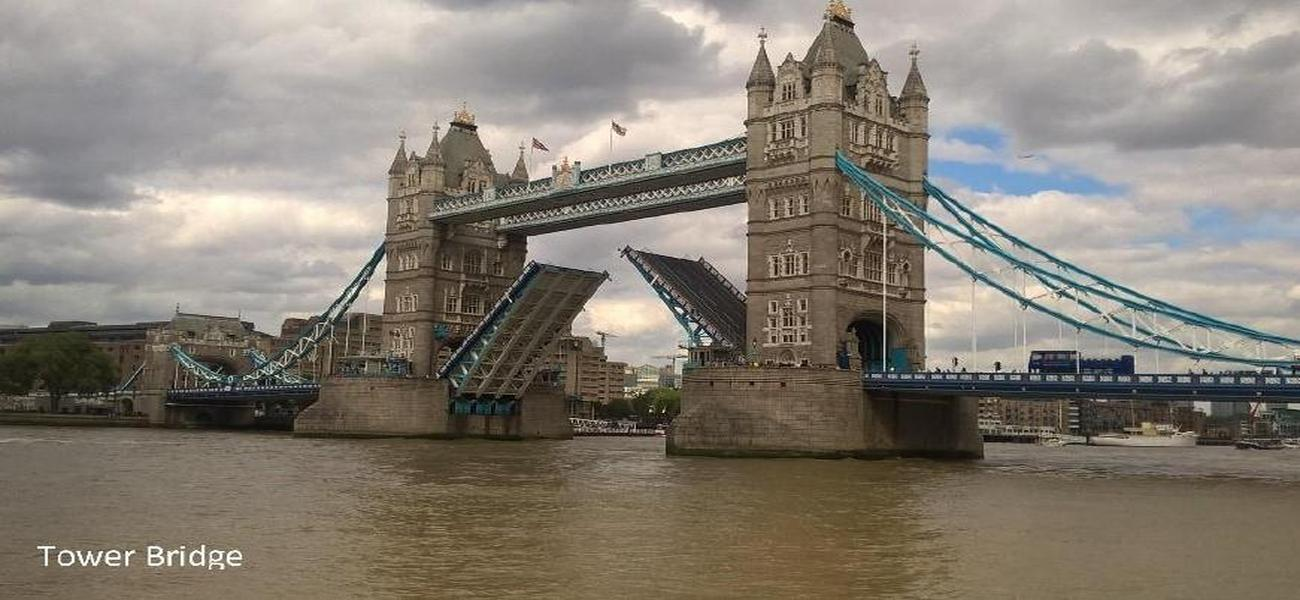

"The image you've provided is of Tower Bridge, which is often mistakenly referred to as London Bridge by those unfamiliar with the area. Tower Bridge is a distinct landmark of London and is a combined bascule and suspension bridge. It crosses the River Thames close to the Tower of London and has become an iconic symbol of the city.\n\nWhile Tower Bridge is sometimes confused with London Bridge, they are not the same structure. London Bridge is a different bridge that is situated upstream and is more functional in design compared to the ornate Tower Bridge. The current London Bridge is a relatively modern structure, having been opened to traffic in 1973, replacing a 19th-century stone-arched bridge which in turn succeeded a series of wooden bridges that have spanned the River Thames in this location since the Roman period."

In [12]:
# Reload the multi-vector retriever to verify that the changes were persisted
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=redis_store,
    id_key="doc_id",
)

# Create RAG chain
chain_multimodal_rag_test = multi_modal_rag_chain(retriever)
# Check retrieval
query = "Tell me something about London bridge."
docs = retriever.get_relevant_documents(query, limit=6)

# We get docs
len(docs)
# Run RAG chain
chain_multimodal_rag_test.invoke(query)

In [17]:
# Get a specific collection
collection = persistent_client_chroma.get_collection("multimodalrag")

# Get all items
results = collection.get()

In [19]:
print(results["metadatas"])

[{'doc_id': '3b69e7a9-0aec-4b3d-93a4-f56b74148c07', 'file_name': '1_London_Brochure', 'index': 0}, {'doc_id': 'b6af05f2-4a33-47d8-a7d3-cc709776a3b2', 'file_name': '1_London_Brochure', 'index': 1}, {'doc_id': '86016e31-04d5-4618-b065-1dc74c4a4464', 'file_name': '1_London_Brochure', 'index': 2}, {'doc_id': '90e45e49-88a7-4154-9cc1-ffd532dced15', 'file_name': '1_London_Brochure', 'index': 3}, {'doc_id': '08ce9332-2fbd-41ee-aa29-196199080373', 'file_name': '1_London_Brochure', 'index': 4}, {'doc_id': '12b2d263-1df0-46b4-b23b-b6a0ee0fea25', 'file_name': '1_London_Brochure', 'index': 0}, {'doc_id': '79da90d4-9b6c-4cb6-8478-bdc541cf038d', 'file_name': '1_London_Brochure', 'index': 1}, {'doc_id': '8e9d80e1-eb15-4b45-b441-1cda653db5d8', 'file_name': '1_London_Brochure', 'index': 2}, {'doc_id': 'f1a9bc47-7b81-452c-a360-096c4369abc2', 'file_name': '1_London_Brochure', 'index': 3}, {'doc_id': '6c38efb1-0348-41a1-a6ed-eca0d081973c', 'file_name': '1_London_Brochure', 'index': 4}, {'doc_id': '2b0998c